In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from LP import LP
from DeepLP import DeepLP
from DeepLP_RBF import DeepLP_RBF
from DeepLP_WeightedRBF import DeepLP_WeightedRBF
import pandas as pd

from utils import *

iris = True
cora = False
label_prob = 0.05
hard = True
percentile = 10

sigma = 3
theta = np.array([ 1 ,  1,  1,  1 ])

In [12]:
nodes = pd.read_csv('cora/selected_content.csv',index_col=0,)
graph = np.loadtxt('cora/graph.csv',delimiter=',')
id_    = np.array(nodes.index)
labels = np.array(nodes['label'])
data   = nodes.loc[:,'feature_0':].as_matrix()

In [18]:
np.sum(nodes['label'])/nodes['label'].shape[0]

0.3020679468242245

### Iris Data

In [2]:
if iris:
    # get labels, features and weights
    # load iris data
    iris   = datasets.load_iris()
    data   = iris["data"]
    labels = iris["target"]

    # get label 0 and 1, and corresponding data
    labels = labels[labels < 2]
    data = data[np.where(labels < 2)]

### Cora Data

### Data Preparation

In [3]:
LX, Ly, UX, Uy, Uy_sol = random_unlabel(data,labels,label_prob=label_prob,hard=hard)
features = np.vstack((LX,UX))
weights = rbf_kernel(features,s=sigma,percentile=percentile)

true_labels = np.hstack((Ly,Uy_sol))
num_features = features.shape[1]
num_labeled = len(Ly)
num_unlabeled = len(Uy)
num_nodes = num_labeled+num_unlabeled
if iris:
    graph = (weights > 0).astype(int)

In [4]:
# prepare features for NN
LY = np.tile(Ly,(Ly.shape[0],1))
np.fill_diagonal(LY, 0.5)
UY = np.tile(Uy,(Ly.shape[0],1))

masked_ = np.hstack((np.identity(LY.shape[0]),np.zeros((Ly.shape[0],Uy.shape[0]))))
true_labeled = np.array([1] * LY.shape[0] + [0] * Uy.shape[0]).reshape(1,num_nodes)

In [5]:
unlabeled_test = np.hstack((np.zeros(LY.shape[0]),np.ones((Uy.shape[0])))).reshape(1,num_nodes)
test_data = {
    'X': np.hstack((Ly,Uy)).reshape(1,num_nodes),
    'y': np.tile(true_labels,(Ly.shape[0],1))[1:2],
    'unlabeled': unlabeled_test,
    'labeled': (1 - unlabeled_test).reshape(1,num_nodes),
    'true_labeled': true_labeled,
    'masked':masked_[0:1]
}

In [6]:
unlabeled_ = np.hstack((np.identity(LY.shape[0]),np.ones((Ly.shape[0],Uy.shape[0]))))
data = {
    'X':np.hstack((LY, UY)),
    'y':np.reshape(true_labels,(1,len(true_labels))),
    'unlabeled':unlabeled_,
    'labeled':1-unlabeled_,
    'true_labeled': true_labeled,
    'masked':masked_
}

# Label Propagation

In [7]:
lp = LP(num_nodes,num_labeled)
Uy_lp = np.rint(lp.closed(weights,Ly))
Uy_lp_iter = np.squeeze(np.rint(lp.iter_(weights,Ly,Uy,100)))

In [8]:
print("[Accuracy] Closed solution:", accuracy(Uy_sol, Uy_lp), " Iter Solution:", accuracy(Uy_sol, Uy_lp_iter))
print("[RMSE] Closed solution", rmse(Uy_sol, Uy_lp), " Iter solution", rmse(Uy_sol, Uy_lp_iter))

[Accuracy] Closed solution: 0.494736842105  Iter Solution: 0.494736842105
[RMSE] Closed solution 0.505263157895  Iter solution 0.505263157895


In [9]:
for iter_ in [1,2,3,4,5,10,100,1000]:
    print(iter_)
    Uy_lp_iter = np.squeeze(np.rint(lp.iter_(weights,Ly,Uy,iter_)))
    print("Objective:", objective(Ly,np.rint(Uy_lp_iter),weights))
    print("Accuracy:", accuracy(Uy_sol,Uy_lp_iter))
    print("RMSE:", rmse(Uy_sol,Uy_lp_iter))

1
Objective: 852.552563203
Accuracy: 0.0
RMSE: 1.0
2
Objective: 852.552563203
Accuracy: 0.0
RMSE: 1.0
3
Objective: 852.552563203
Accuracy: 0.0
RMSE: 1.0
4
Objective: 104.02108101
Accuracy: 0.494736842105
RMSE: 0.505263157895
5
Objective: 279.656326973
Accuracy: 0.547368421053
RMSE: 0.452631578947
10
Objective: 702.671830857
Accuracy: 0.726315789474
RMSE: 0.273684210526
100
Objective: 104.02108101
Accuracy: 0.494736842105
RMSE: 0.505263157895
1000
Objective: 104.02108101
Accuracy: 0.494736842105
RMSE: 0.505263157895


# DeepLP

In [11]:
dlp = DeepLP(100, num_nodes, weights, 1)

In [12]:
pred_dlp = dlp.labelprop(test_data)
Uy_dlp = np.rint(pred_dlp[:,num_labeled:]).reshape(num_unlabeled)

In [13]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp))
print("RMSE:", rmse(Uy_sol,Uy_dlp))
print("Objective:", objective(Ly,Uy_dlp,dlp.get_val(dlp.W)))

Accuracy: 0.494736842105
RMSE: 0.505263157895
Objective: 1.40468609333


# DeepLP_RBF

In [34]:
dlp_rbf = DeepLP_RBF(100, num_nodes, features, graph, sigma, lr=0.01)

In [35]:
pred_dlp_rbf = dlp_rbf.labelprop(test_data)
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [33]:
Uy_dlp_rbf.shape, pred_dlp_rbf

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]))

In [32]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_val(dlp_rbf.W)))

Accuracy: 0.494736842105
RMSE: 0.505263157895
Objective: 1.40468716621


In [18]:
dlp_rbf.train(data,test_data,100)

epoch: -1 labeled loss: 0.32181 unlabeled loss: 0.238357 accuracy: 0.798 sol unlabeled loss: 0.21795 sol accuracy: 0.494737
--- 2.427772283554077 seconds ---
epoch: 0 labeled loss: 0.320379 unlabeled loss: 0.237222 accuracy: 0.798 sol unlabeled loss: 0.216616 sol accuracy: 0.494737
--- 0.2604100704193115 seconds ---
sigma: 2.94994
epoch: 10 labeled loss: 0.293238 unlabeled loss: 0.215925 accuracy: 0.798 sol unlabeled loss: 0.192016 sol accuracy: 0.663158
--- 2.0724289417266846 seconds ---
sigma: 2.3886
epoch: 20 labeled loss: 0.155663 unlabeled loss: 0.11229 accuracy: 0.898 sol unlabeled loss: 0.0846637 sol accuracy: 1.0
--- 2.08616304397583 seconds ---
sigma: 1.58441
epoch: 30 labeled loss: 0.0141883 unlabeled loss: 0.0141866 accuracy: 1.0 sol unlabeled loss: 0.00838754 sol accuracy: 1.0
--- 2.066554069519043 seconds ---
sigma: 0.916566
epoch: 40 labeled loss: 0.0121982 unlabeled loss: 0.0199817 accuracy: 0.988 sol unlabeled loss: 0.0160651 sol accuracy: 0.978947
--- 2.060992002487182

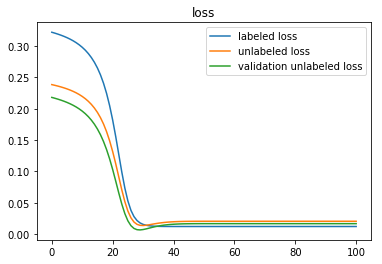

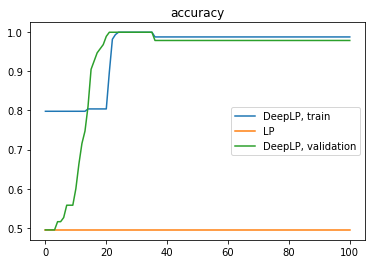

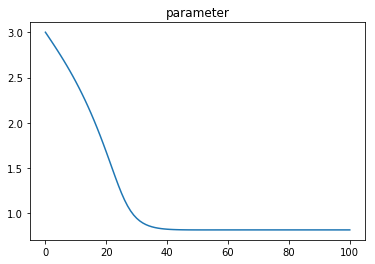

In [19]:
dlp_rbf.plot()

# DeepLP_WeightedRBF

In [45]:
dlp_wrbf = DeepLP_WeightedRBF(100, num_nodes, features, graph, 
                              sigma, theta, lr=0.01, regularize=0.1)

Tensor("while_7/matmul:0", shape=(?, 100), dtype=float32)


In [46]:
pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)

In [47]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_wrbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_wrbf))
print("Objective:", objective(Ly,Uy_dlp_wrbf,dlp_wrbf.get_val(dlp_wrbf.W)))

Accuracy: 0.494736842105
RMSE: 0.505263157895
Objective: 1.40468716621


In [48]:
dlp_wrbf.train(data,test_data,100)

epoch: -1 labeled loss: 0.335805 unlabeled loss: 0.246603 accuracy: 0.798 sol unlabeled loss: 0.227112 sol accuracy: 0.494737
epoch: 0 labeled loss: 0.330857 unlabeled loss: 0.242631 accuracy: 0.798 sol unlabeled loss: 0.222527 sol accuracy: 0.494737
theta: [ 1.0497371   0.98897547  1.05002785  1.04952002]
epoch: 10 labeled loss: 0.278461 unlabeled loss: 0.187618 accuracy: 0.804 sol unlabeled loss: 0.160501 sol accuracy: 0.926316
theta: [ 1.20635104  1.03572583  1.58161366  1.19338715]
epoch: 20 labeled loss: 0.213658 unlabeled loss: 0.104719 accuracy: 0.962 sol unlabeled loss: 0.0776316 sol accuracy: 1.0
theta: [ 1.0881207   1.1000663   2.14607882  1.18059134]
epoch: 30 labeled loss: 0.200902 unlabeled loss: 0.0706981 accuracy: 0.996 sol unlabeled loss: 0.0480275 sol accuracy: 1.0
theta: [ 1.0294342   1.10011005  2.41645741  1.12256896]
epoch: 40 labeled loss: 0.200769 unlabeled loss: 0.0673777 accuracy: 0.996 sol unlabeled loss: 0.0452802 sol accuracy: 1.0
theta: [ 1.02472603  1.0986

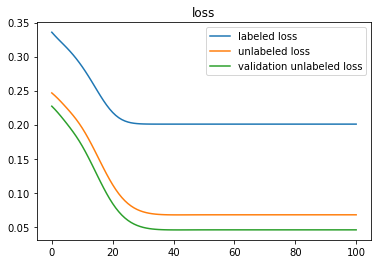

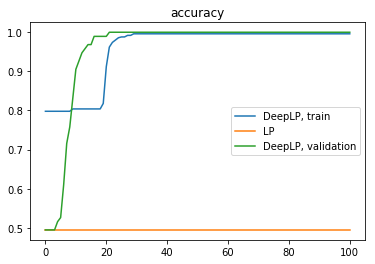

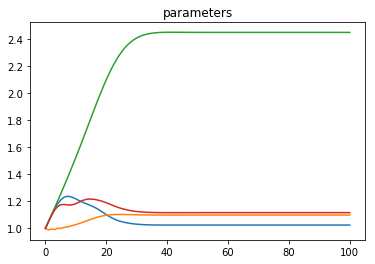

In [49]:
dlp_wrbf.plot()

In [17]:
sigmas = np.arange(0.1,5,0.01)

ValueError: operands could not be broadcast together with shapes (5,) (95,) 

In [19]:
len(sigmas)

495

In [21]:
accuracies = []
rmses = []
objectives = []

for i,sigma_ in enumerate(sorted(sigmas)):
    print(i)
    if i % 50 == 0:
        print(i)
    dlp_rbf = DeepLP_RBF(100, num_nodes, features, graph, sigma_, lr=0.01)    
    pred_dlp_rbf = dlp_rbf.labelprop(test_data,sigma=sigma_)
    Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)
#     print(sigma_)
#     print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
#     print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
#     print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_val(dlp_rbf.W)))
    
    accuracies.append(accuracy)
    rmses.append(rmse)
    objectives.append(objective)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
2

In [36]:
from sklearn.utils.extmath import cartesian
l = np.arange(0,4.5,0.1)
l4 = [l for i in range(4)]
thetas = cartesian(l4)

In [37]:
accuracies = []
rmses = []
objectives = []
dlp_wrbf = DeepLP_WeightedRBF_t(10, num_nodes, features, graph, np.var(features), 'a', 0.01)

TypeError: __init__() missing 1 required positional argument: 'session'

In [38]:

for i,theta_ in enumerate(thetas): 
#     print(theta_)
    if i % 1 == 0:
        print(i)
    test_data['theta'] = theta_.reshape(1,4)
    
    pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
    Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)
    accuracies.append(accuracy(Uy_sol,Uy_dlp_wrbf))
    rmses.append(rmse(Uy_sol,Uy_dlp_wrbf))
#     print("Accuracy:", accuracies[-1])
#     print("RMSE:", rmses[-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 